In [1]:
import glob, pylab, pandas as pd


In [2]:
import pydicom, numpy as np

In [3]:
df=pd.read_csv('stage_2_train_labels.csv')

In [4]:
print(df.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object


In [5]:
print(df.iloc[1])

patientId    00313ee0-9eaa-42f4-b0ab-c148ed3241cd
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 1, dtype: object


In [11]:
print(df.iloc[2])

patientId    00322d4d-1c29-4943-afc9-b6754be640eb
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 2, dtype: object


#this file has the NaN values, which will have be handled later

Overview of DICOM files and medical images¶
Medical images are stored in a special format known as DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data. In Python, one popular library to access and manipulate DICOM files is the pydicom module. To use the pydicom library, first find the DICOM file for a given patientId by simply looking for the matching file in the stage_1_train_images/ folder, and the use the pydicom.read_file() method to load the data:

In [7]:
patientId = df['patientId'][0]

In [8]:
dcm_file = 'stage_2_train_images/%s.dcm' % patientId

In [9]:
dcm_data = pydicom.read_file(dcm_file)

In [10]:
im = dcm_data.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


In [12]:
print(dcm_data)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

(-0.5, 1023.5, 1023.5, -0.5)

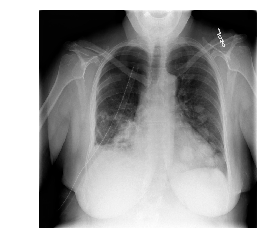

In [13]:
pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('off')

In [19]:
def parse_data(df):

    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': 'stage_2_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

In [20]:
parsed = parse_data(df)


In [21]:
print(parsed['00436515-870c-4b36-a041-de91049b9ab4'])
print(parsed['085a6486-c3b3-4ca2-80f1-be07d23e853b'])


{'dicom': 'stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm', 'label': 1, 'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]]}
{'dicom': 'stage_2_train_images/085a6486-c3b3-4ca2-80f1-be07d23e853b.dcm', 'label': 1, 'boxes': [[231.0, 665.0, 284.0, 185.0], [325.0, 147.0, 225.0, 158.0], [422.0, 332.0, 249.0, 155.0]]}


In [22]:
def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    pylab.imshow(im, cmap=pylab.cm.gist_gray)
    pylab.axis('off')

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

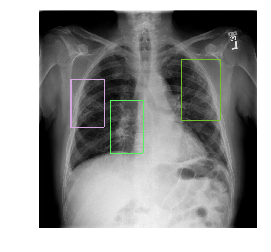

In [23]:
draw(parsed['085a6486-c3b3-4ca2-80f1-be07d23e853b'])


In [25]:
df.head(50)


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [26]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
patientId    30227 non-null object
x            9555 non-null float64
y            9555 non-null float64
width        9555 non-null float64
height       9555 non-null float64
Target       30227 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [28]:
df['patientId'].value_counts().head(50)

31764d54-ea3b-434f-bae2-8c579ed13799    4
ee820aa5-4804-4984-97b3-f0a71d69702f    4
76f71a93-8105-4c79-a010-0cfa86f0061a    4
8dc8e54b-5b05-4dac-80b9-fa48878621e2    4
0ab261f9-4eb5-42ab-a9a5-e918904d6356    4
32408669-c137-4e8d-bd62-fe8345b40e73    4
349f10b4-dc3e-4f3f-b2e4-a5b81448ce87    4
0d5bc737-03de-4bb8-98a1-45b7180c3e0f    4
1bf08f3b-a273-4f51-bafa-b55ada2c23b5    4
7d674c82-5501-4730-92c5-d241fd6911e7    4
1c44e0a4-4612-438f-9a83-8d5bf919cb67    4
3239951b-6211-4290-b237-3d9ad17176db    4
0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d    4
d947215e-c4c5-4907-8d47-0735a0ba4fb9    3
784a3ed0-2565-430f-819f-f713e1775344    3
338a1c2f-60a7-4656-ba2c-8c99103da696    3
338e80a6-7b26-4133-b051-a40e063d39a3    3
6c490407-f039-4eaf-94c8-1bff41b09f6c    3
3fdcd01b-1029-40c9-be8a-a72876d0323b    3
228b3dc1-f78a-4ac9-b213-2a416583d063    3
e3884258-8083-4b8e-b952-9adc91a7f0f3    3
c252072c-c7c9-40a8-819b-5c7952d10bf2    3
3218b157-1f46-4da3-863f-9b97ae22308f    3
3c1fdc6b-2e9a-46f7-8dbd-28d4155f9b

In [29]:
#Count of rows per patientID has 4 values:

df['patientId'].value_counts().value_counts()


1    23286
2     3266
3      119
4       13
Name: patientId, dtype: int64

In [30]:
#Each of patients without pneumonia has only one row in dataset:

df[df['Target'] == 0]['patientId'].value_counts().value_counts()


1    20672
Name: patientId, dtype: int64

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
#Load additional Data


In [34]:
class_info = pd.read_csv('stage_2_detailed_class_info.csv')
train_labels = pd.read_csv('stage_2_train_labels.csv')

In [36]:
df_marged = pd.merge(left = class_info, right = train_labels, how = 'left', on = 'patientId')


In [37]:
df_marged.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37629 entries, 0 to 37628
Data columns (total 7 columns):
patientId    37629 non-null object
class        37629 non-null object
x            16957 non-null float64
y            16957 non-null float64
width        16957 non-null float64
height       16957 non-null float64
Target       37629 non-null int64
dtypes: float64(4), int64(1), object(2)
memory usage: 2.3+ MB


In [38]:
df_marged = df_marged.drop_duplicates()
df_marged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 37626
Data columns (total 7 columns):
patientId    30227 non-null object
class        30227 non-null object
x            9555 non-null float64
y            9555 non-null float64
width        9555 non-null float64
height       9555 non-null float64
Target       30227 non-null int64
dtypes: float64(4), int64(1), object(2)
memory usage: 1.8+ MB


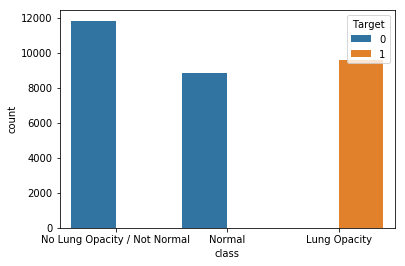

In [40]:
sns.countplot(x = 'class', hue = 'Target', data = df_marged);
